## This notebook displays sleep stages annotations over the recordings and gives the modules to extract awake moments and invalid moments

In [46]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import mne
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from tinnsleep.config import Config
from tinnsleep.reports import preprocess, reporting, generate_bruxism_report
from tinnsleep.utils import merge_labels_list
from tinnsleep.data import CreateRaw, RawToEpochs_sliding, CleanAnnotations, AnnotateRaw_sliding
import xlrd
import csv
import time
from datetime import *
print("config loaded")


config loaded


## Visualisation functions

In [18]:
def crappy_get_visual_ready(RAW):    
        #Preparing raw for visualisation
        chan = RAW.info["ch_names"]
        picks_chan = ["E1","E2", 'C3', 'C4', '1', '2',"Airflow",'Abdomen', 'ECG', "Volume audio"]
        RAW  = CreateRaw(RAW[picks_chan][0], RAW.info["sfreq"], picks_chan, ch_types='emg')        # pick channels and load
        RAW  = RAW.load_data()
        dat=RAW.get_data()
        dat[-2]=[dat[-2][i]*0.01 for i in range(len(dat[1]))]
        dat[-4]=[dat[-4][i]*0.0005 for i in range(len(dat[1]))]
        dat[-1]=[dat[-1][i]*0.0005 for i in range(len(dat[1]))]
        RAW  = CreateRaw(dat, RAW.info["sfreq"], picks_chan, ch_types='emg') 
        RAW  = RAW.filter(20., 99., n_jobs=4, 
                          fir_design='firwin', filter_length='auto', phase='zero-double',
                          picks=['1', '2'])
        RAW  = RAW.filter(1., 20., n_jobs=4, 
                          fir_design='firwin', filter_length='auto', phase='zero-double',
                          picks=["E1","E2", 'C3', 'C4'])
        RAW.rename_channels({'Airflow': 'R middle ear', '1':'R Suprahyiod', '2': 'R Masseter' })
        return RAW
        
def annotate_it(RAW, dict_annotations, annotations):
        #-----------------labelling datas with sleep stages annotations -----------------------------------
        #Annotating the raw
        RAW = CleanAnnotations(RAW)
        RAW = AnnotateRaw_sliding(RAW, annotations, 
                        dict_annotations=dict_annotations, duration=RAW.info["sfreq"]*30, interval=RAW.info["sfreq"]*30)

        print("Raw annotated")
        RAW.plot(scalings = "auto")

## Preprocessing of XLS files and saving them to pickle:
- Adding invalid epochs
- determining sleep onset epoch and memorizing it
- determining final awakening epoch and memorizing it

In [45]:
#The following function should be included somewhere in the code files and pytested.
def process_csv(df):
     # Retrieving the timestamps of each epoch
    get_eps=df["Horodatage"].tolist()[1:]  # Getting rid of the first element which is an empty list
    # Retrieving the sleep stage of each epoch
    get_stages = df["Sommeil"].tolist()[1:]    # Getting rid of the first element which is an empty list
    # ------------- detecting missing epochs and completing sleep stages with invalid labels -------------
    #initialisation of a new sleep stages list
    sleep_stages=[get_stages[0]]
    for i in range(len(get_eps)-1):
        #getting time difference between two consecutive epochs. It should be of 30 seconds
        diff = int((get_eps[i+1]-get_eps[i]).total_seconds())
        #case where we pass midnight
        if diff < 0:
            diff = 3600*24 + int((get_eps[i+1]-get_eps[i]).total_seconds())
        
        #Deals when there is one or more epochs missing
        if diff>30:
            if diff== 60: #in this case, we have only one epoch missing,
                # we can assume in this case that the sleep stage has not changed and we just rewrite the preceding value
                sleep_stages.append(sleep_stages[-1])
                #We add the next sleep stage to the list
                sleep_stages.append(get_stages[i+1])
            else:
                #If we miss more than one epoch, we add several invalid labels for all missing epochs
                for j in range(int(diff/30)-1):
                    sleep_stages.append("Invalid")
                #We add the next sleep stage to the list
                sleep_stages.append(get_stages[i+1])
        else:
            #We add the next sleep stage to the list
            sleep_stages.append(get_stages[i+1])
            
    
    # ------------- finding the first sleep onset and the last awakening -------------
    flag_endor=False
    flag_rev=False
    labs=["Éveil", "Invalid", np.nan, "eveil"]  #different cases where the patient is considered awake
    for i in range(len(sleep_stages)):
        #detecting first sleep onset
        if not labs.__contains__(sleep_stages[i]):
            if not flag_endor:
                ind_deb=i
                flag_endor=True
        #detecting last asleep moment
        if not labs.__contains__(sleep_stages[-i-1]):

            if not flag_rev:
                ind_fin=i
                flag_rev=True
    #assessing time of sleep onset
    deb = get_eps[0]+ timedelta(seconds=ind_deb*30)
    #assessing time of the final awakening
    fin = get_eps[-1]- timedelta(seconds=ind_fin*30)
    #Storing results for future use
    if ind_fin>0:
        sleep_stages_cropped = sleep_stages[ind_deb:-ind_fin]
    else: #we go until the end of slee_stages
        sleep_stages_cropped = sleep_stages[ind_deb:]
    return sleep_stages_cropped, deb.time(), fin.time()


root_folder = os.path.sep.join(os.getcwd().split(os.path.sep)[:-1]) + os.path.sep + "notebooks" + os.path.sep + "data" + os.path.sep
csv_sleep_staging = os.listdir(root_folder + "sleep_staging" + os.path.sep)
all_s_stages = {}
for file in csv_sleep_staging:
    df = pd.read_excel(root_folder + "sleep_staging" + os.path.sep + file, sep=";", encoding='latin-1')
    # print(df)
    sleep_stages, deb, fin = process_csv(df)
    all_s_stages[file[:-4] + ".edf"] = (sleep_stages, deb, fin)

df_to_save = pd.DataFrame(all_s_stages)
df_to_save.to_pickle(root_folder + "sleep_stages.pkl")

    

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


## Importing sleep stages from pickle

In [47]:
dict_sleep_stages = pd.read_pickle("data/sleep_stages.pkl")

## Sleep stage visualisation on awaken-cropped recording :

Files processed: 
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\1MF19_nuit_son.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\Zeta\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Raw annotated


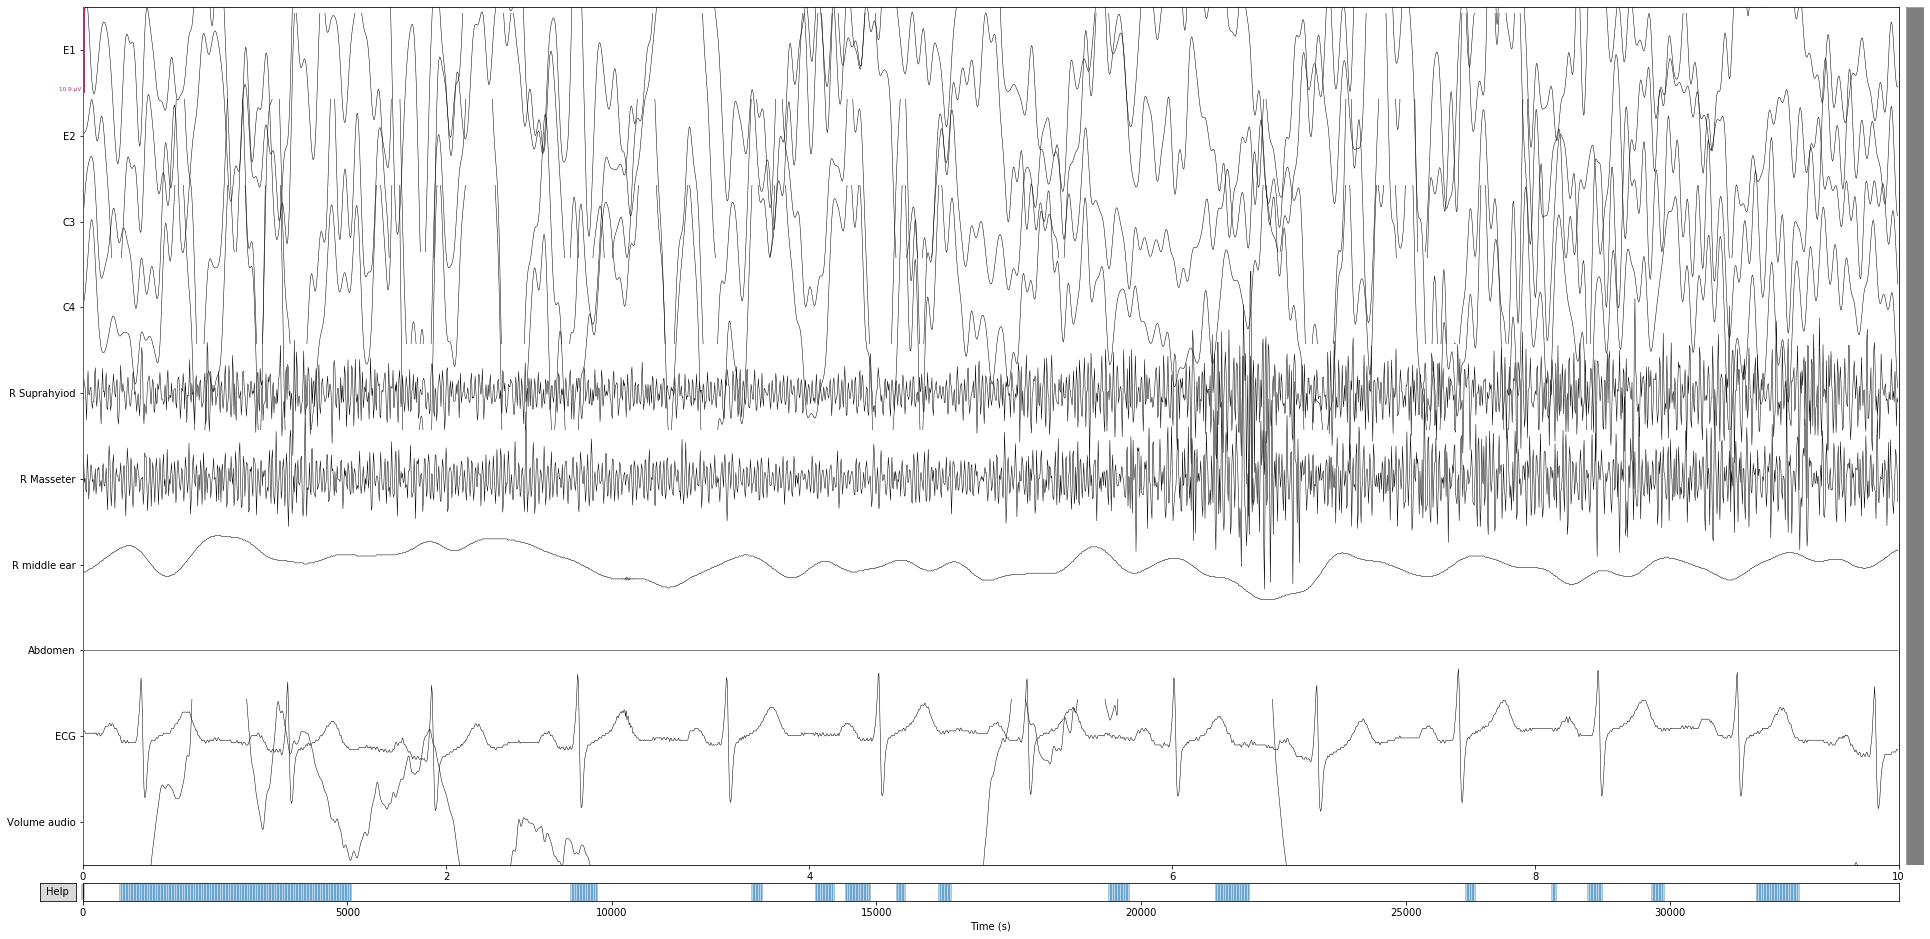

Raw annotated


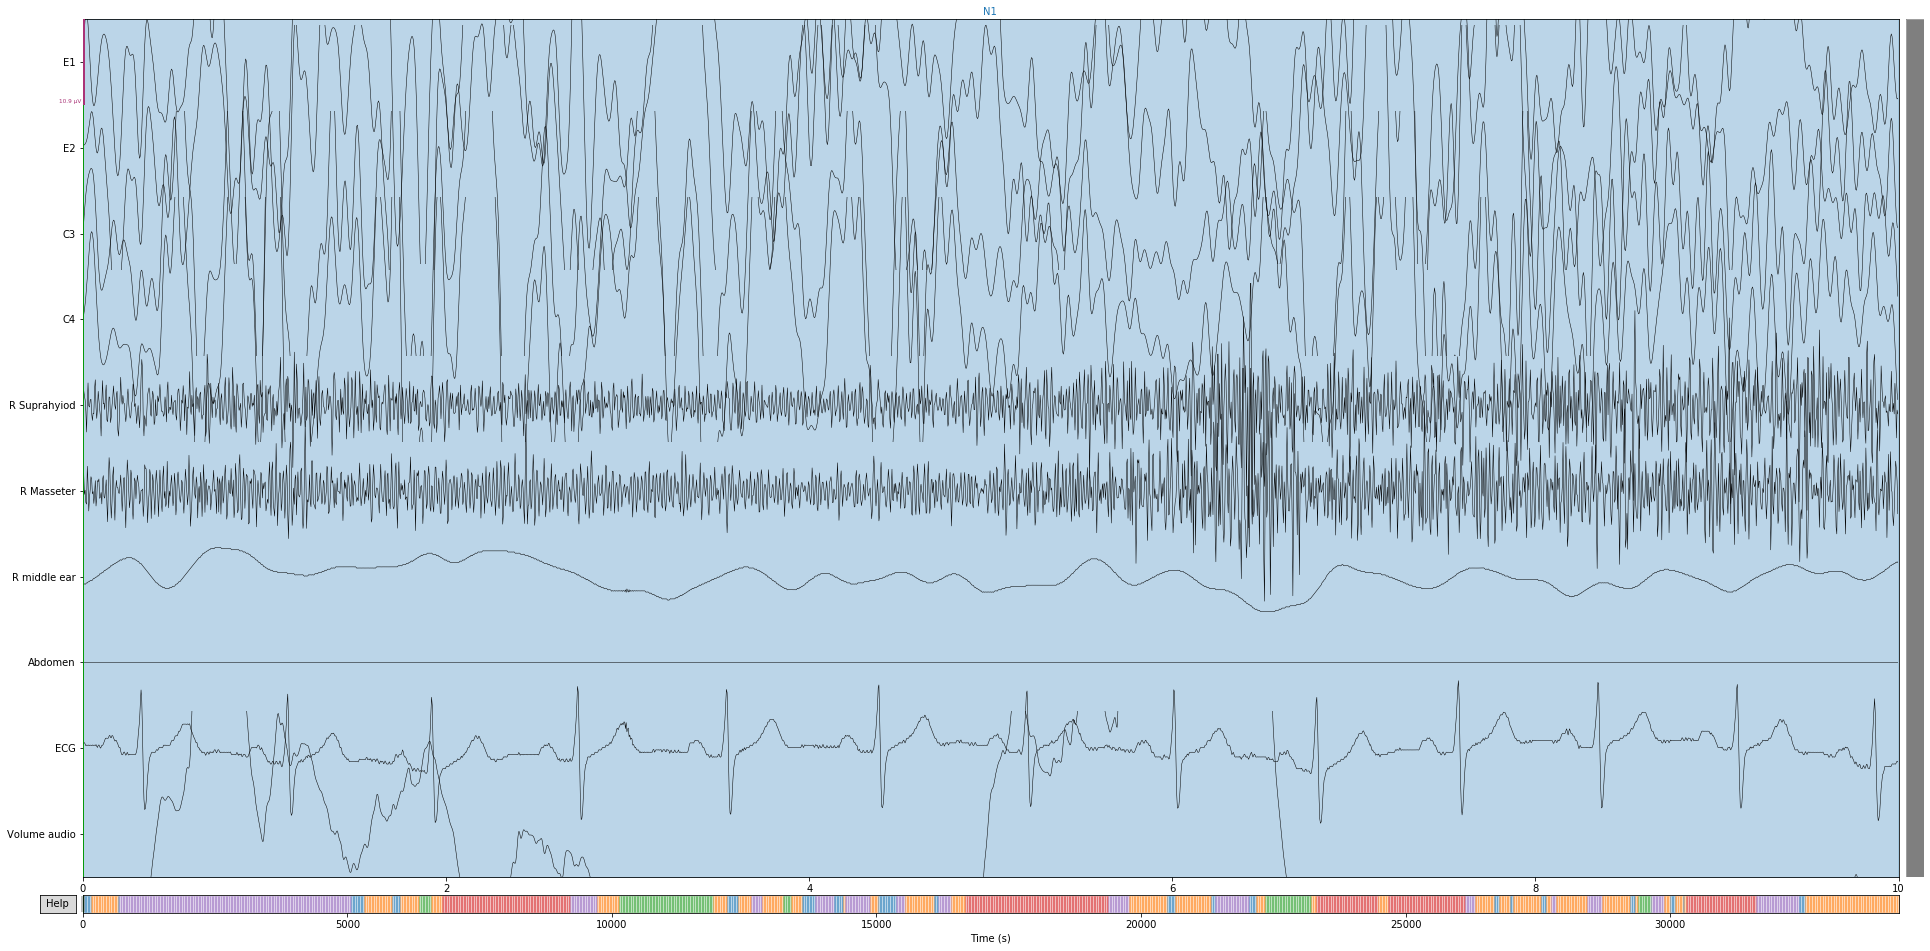

In [48]:
import warnings
from time import time


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    results={}
    print("Files processed: ")
    start = time()
    for filename in Config.bruxisme_files[:20]:
        
        file = filename.split(os.path.sep)[-1]
        if dict_sleep_stages.keys().__contains__(file):
            raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading
            
            #Getting sleep stages and processing them
            sleep_stages, deb, fin = dict_sleep_stages[file]
            
            #Cropping Raw between sleep onset and first awakening
            tmin_sleep=(datetime.strptime(str(deb), '%H:%M:%S') - datetime.strptime(str(raw.info["meas_date"].time()), '%H:%M:%S')).total_seconds()
            tmax_sleep = (datetime.strptime(str(fin), '%H:%M:%S') - datetime.strptime(str(raw.info["meas_date"].time()), '%H:%M:%S')).total_seconds()
            if tmax_sleep < 0:
                tmax_sleep = 3600*24 + tmax_sleep
            croptimes=dict(tmin=tmin_sleep, tmax=tmax_sleep+30)
            raw.crop(**croptimes)
            
            
            #Getting list of awake and invalid annotations
            labs=["Éveil", "Invalid", np.nan, "eveil"]  #different cases where the patient is considered awake
            sleep_stages=np.asanyarray(sleep_stages)
            valid_labels = np.full((len(sleep_stages),), True, dtype=bool)
            for lab in labs:
                valid_labels[np.where(sleep_stages==lab)]=False
            #valid_labels list ready to be joined with the rest of the analysis

            
            awake_moments={"True":"awake"}
            raw = crappy_get_visual_ready(raw)
            annotate_it(raw, awake_moments, np.invert(valid_labels))
            
            sleep_labels = {"awake": "awake", "N1":"N1", "N2":"N2", "N3":"N3", "REM":"REM"}
            annotate_it(raw, sleep_labels, sleep_stages)
            
            
        
        
        
os.chdir(current_folder)